<a href="https://colab.research.google.com/github/Abdulkarim02/Hand-written-image-classification/blob/main/Mnist_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
import torch.nn.functional as F

from torchvision.datasets import mnist,MNIST
from torchvision.transforms.functional import to_tensor


from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn

from tqdm import tqdm

In [92]:
mnist_train = MNIST(root= "./datasets",train=True, transform= to_tensor, download= True)
mnist_test = MNIST(root= "./datasets",train=False , transform= to_tensor, download= True)

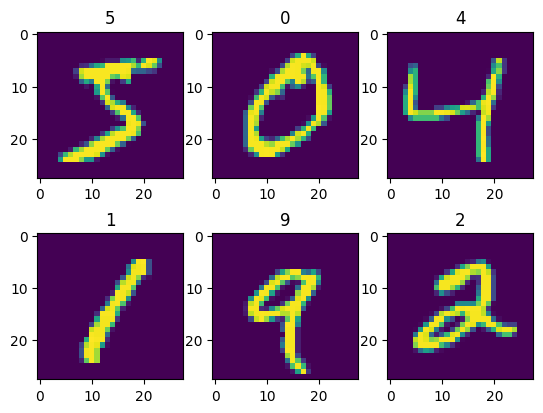

In [93]:
plt.Figure(figsize=(8,4))

for i in range(6):
  plt.subplot(2,3,i+1)

  sample,lable = mnist_train[i]
  plt.imshow(sample.squeeze())
  plt.title(label=lable)


plt.show()

In [94]:
train_loader= DataLoader(mnist_train, batch_size=32, shuffle= True, num_workers=2)
test_loader= DataLoader(mnist_test, batch_size=32, shuffle= False, num_workers=2)

In [95]:
X_batch, y_batch = next(iter(train_loader))
print(f"Training batch input shape: {X_batch.shape}")
print(f"Training batch labels shape: {y_batch.shape}")

Training batch input shape: torch.Size([32, 1, 28, 28])
Training batch labels shape: torch.Size([32])


In [96]:
class Model(nn.Module):
  def __init__(self,in_features,out_features,hidden):
    super().__init__()
    self.layer1 = nn.Linear(in_features, hidden)
    self.layer2 = nn.Linear(hidden,hidden)
    self.layer3 = nn.Linear(hidden,hidden)
    self.layer4 = nn.Linear(hidden,out_features)


    self.relu = nn.ReLU()

  def forward(self,x):
    z= self.relu(self.layer1(x))
    z= self.relu(self.layer2(z))
    z= self.relu(self.layer3(z))
    z= self.layer4(z)

    return z





In [97]:
def train_epoch(model,train_loader,optim,loss_fn,device):
  model.train()

  avg_loss=0
  for X,y in train_loader:
    X= X.view(X.shape[0],-1).to(device)
    y= y.to(device)

    y_pred = model(X)
    loss =loss_fn(y_pred,y)
    optim.zero_grad()
    loss.backward()
    optim.step()

    avg_loss += loss.item()

  avg_loss = avg_loss/len(train_loader)
  return avg_loss


def test_epoch(model, test_loader, loss_fn, device):
  model.eval()

  avg_loss = 0
  accuracy = 0
  total_samples= 0
  with torch.inference_mode():
    for X,y in test_loader:
      X= X.view(X.shape[0],-1).to(device)
      y= y.to(device)

      output= model(X)
      loss = loss_fn(output,y)

      prob = F.softmax(output, dim=1)
      y_pred = torch.argmax(prob,dim=1)

      avg_loss += loss.item()
      total_samples+= X.shape[0]
      accuracy+= (y==y_pred).sum()

  avg_loss = avg_loss/len(test_loader)
  accuracy = accuracy/total_samples

  return avg_loss, accuracy


In [98]:
def train(model, train_loader, test_loader, optim ,loss_fn ,device, epochs= 10):
  train_loss = []
  test_loss = []

  for epoch in tqdm(range(epochs),desc=f"training"):
    train_ls =train_epoch(model,train_loader, optim, loss_fn, device)
    test_ls , accuracy= test_epoch(model, test_loader , loss_fn, device)

    train_loss.append(train_ls)
    test_loss.append(test_ls)

    if epoch % 2 == 0: # Changed condition to print every 10 epochs including epoch 0
      print(f"{epoch} train loss :{train_ls} | test loss :{test_ls} | accuracy :{accuracy}")

  return train_loss,test_loss

In [99]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
in_features = 1*28*28
out_features = 10
hidden = 16
device

'cuda'

In [100]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = Model(in_features,out_features,hidden)
model.to(device)

Model(
  (layer1): Linear(in_features=784, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=10, bias=True)
  (relu): ReLU()
)

In [101]:
optim = torch.optim.AdamW(model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [102]:
train_loss , test_loss = train(model,train_loader, test_loader, optim , loss_fn, device, epochs= 10)

training:  10%|█         | 1/10 [00:13<02:00, 13.39s/it]

0 train loss :0.5515097340067228 | test loss :0.2989651591252214 | accuracy :0.9111999869346619


training:  30%|███       | 3/10 [00:39<01:32, 13.18s/it]

2 train loss :0.22282855760256448 | test loss :0.2095897619325382 | accuracy :0.9371999502182007


training:  50%|█████     | 5/10 [01:05<01:05, 13.05s/it]

4 train loss :0.17972247532407443 | test loss :0.1851504814190665 | accuracy :0.9440000057220459


training:  70%|███████   | 7/10 [01:31<00:39, 13.00s/it]

6 train loss :0.1567193183342616 | test loss :0.17452014983444217 | accuracy :0.9470999836921692


training:  90%|█████████ | 9/10 [01:57<00:12, 12.98s/it]

8 train loss :0.14264783610527715 | test loss :0.16207364816836026 | accuracy :0.950499951839447


training: 100%|██████████| 10/10 [02:10<00:00, 13.04s/it]


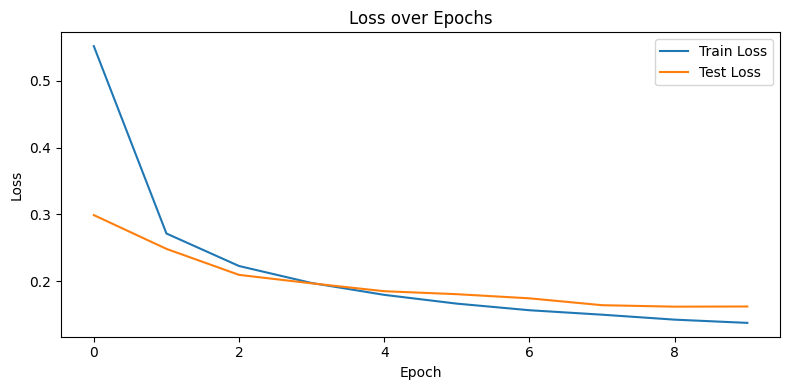

In [103]:
plt.figure(figsize=(8, 4))

plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

torch.Size([32, 1, 28, 28])
1


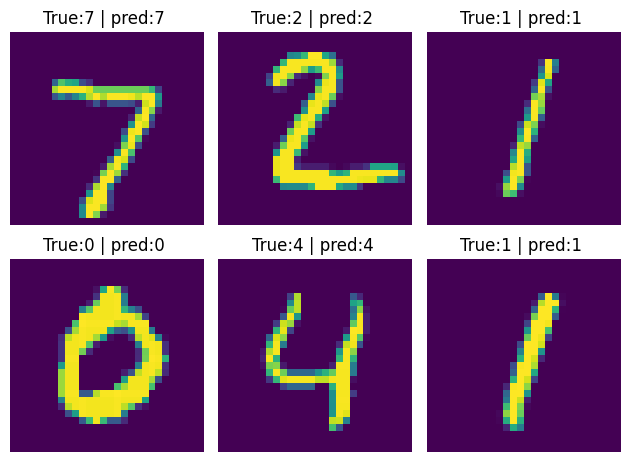

In [104]:
X_batch , y_batch = next(iter(test_loader))

X_batch = X_batch.to(device)
y_batch = y_batch.to(device)
print(X_batch.shape)
model.eval()
with torch.inference_mode():
  output = model(X_batch.view(32,-1))
  y_pred = torch.argmax(output,dim=1)

print((y_pred!=y_batch).sum().item())
plt.Figure(figsize=(8,4))
num_samples =6
for i in range(num_samples):
  plt.subplot(2,3,i+1)
  plt.imshow(X_batch[i].cpu().squeeze())
  plt.title(f"True:{y_batch[i]} | pred:{y_pred[i]} ")
  plt.axis('off')
plt.tight_layout()
